Binned acquisition
==================

In this tutorial we will demonstrate the sequencer based acquisition binning procedure. The binning process is applied on the input path
after real-time demodulation, (weighed) integration, IQ rotation and discretization. It allows storing both the integration and discretization
results on the fly without intervention of the host PC in up to 131072 bins. It also allows averaging those bins on the fly as well (see section [Acquisition](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html#acquisitions)). We will show this by using a Pulsar QRM and directly connecting outputs 
$\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the Pulsar QRM's sequencers to sequence waveforms on 
the outputs and simultaneously acquire the resulting waveforms on the inputs.

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
#Set up the environment.
import pprint
import os
import scipy.signal
import math
import json
import matplotlib.pyplot
import numpy

from pulsar_qrm.pulsar_qrm import pulsar_qrm

#Connect to the Pulsar QRM at default IP address.
pulsar = pulsar_qrm("qrm", "192.168.0.2")

#Reset the instrument for good measure.
pulsar.reset()
print("Status:")
print(pulsar.get_system_status())

Status:
{'status': 'OKAY', 'flags': []}


Generate waveforms and weights
------------------------------

Next, we need to create the waveforms used by the sequence for playback on the outputs as well as weights used by the sequence for weighed
integrations.

In [2]:
#Waveform and weight parameters
waveform_weight_length = 600 #nanoseconds
    
#Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms_weights = {
                "gaussian": {"data": [], "index": 0},
                "sine":     {"data": [], "index": 1},
                "block":    {"data": [], "index": 2}
            }

#Create gaussian waveform/weight
if "gaussian" in waveforms_weights:
    waveforms_weights["gaussian"]["data"] = scipy.signal.gaussian(waveform_weight_length, std=0.12 * waveform_weight_length)

#Create sine waveform/weight
if "sine" in waveforms_weights:
    waveforms_weights["sine"]["data"] = [math.sin((2*math.pi/waveform_weight_length)*i) for i in range(0, waveform_weight_length)]

#Create block waveform/weight
if "block" in waveforms_weights:
    waveforms_weights["block"]["data"] = [1.0 for _ in range(0, waveform_weight_length)]


Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for it's acquisition list. In this case we will create 4 acquisition specifications that each create multiple bins.

In [3]:
#Acquisitions
acquisitions = {"non_weighed":  {"num_bins": 10,
                                 "index":    0},
                "weighed":      {"num_bins": 10,
                                 "index":    1},                 
                "large":        {"num_bins": 131072,
                                 "index":    2},
                "avg":          {"num_bins": 10,
                                 "index":    3}}

Create Q1ASM program
--------------------

Now that we have the waveform and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms and triggers the acquisitions.
In this case we will simply trigger 10 non-weighed acquisitions and store each acquisition in a separate bin.

In [4]:
#Sequence program.
seq_prog = """
      move    0,R0        #Loop iterator.
      nop

loop: acquire 0,R0,1200   #Acquire bins and store them in "non_weighed" acquisition.
      add     R0,1,R0     #Increment iterator
      nop                 #Wait a cycle for R0 to be available.
      jlt     R0,10,@loop #Run until number of iterations is done.

      stop                #Stop.
"""

Upload sequence
---------------

Now that we have the waveform, weights and acquisition specifications and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [5]:
#Reformat waveforms/weights to lists if necessary.
for name in waveforms_weights:
    if str(type(waveforms_weights[name]["data"]).__name__) == "ndarray":
        waveforms_weights[name]["data"] = waveforms_weights[name]["data"].tolist()  # JSON only supports lists

#Add sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": waveforms_weights, "weights": waveforms_weights, "acquisitions": acquisitions, "program": seq_prog}
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0, which will drive outputs $\text{O}^{[1-2]}$ and acquire on inputs $\text{I}^{[1-2]}$.

In [6]:
#Upload waveforms, weights and programs.
pulsar.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "sequence.json"))

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers. To keep it simple we will set a DC signal on the outputs of the instrument by enabling the sequencer offsets and disabling the modulation. These DC signals will then be acquired through the inputs, so we will also disable the demodulation on the input path. Furthermore, since we are running non-weighed integrations we need to specify the integration length. This integration length will be used for every non-weighed integration moving forward. We will also put the integration result phase rotation to 0 degrees and discretation threshold to 0.

In [7]:
#Configure scope mode
pulsar.scope_acq_sequencer_select(0)
pulsar.scope_acq_trigger_mode_path0("sequencer")
pulsar.scope_acq_trigger_mode_path1("sequencer")

#Configure the sequencer
pulsar.sequencer0_offset_awg_path0(0.5)
pulsar.sequencer0_offset_awg_path1(0.5)
pulsar.sequencer0_mod_en_awg(False)
pulsar.sequencer0_demod_en_acq(False)
pulsar.sequencer0_integration_length_acq(1000)
pulsar.sequencer0_phase_rotation_acq(0)
pulsar.sequencer0_discretization_threshold_acq(0)

#Map sequencer to specific outputs (but first disable all sequencer connections)
for sequencer in range(0, 6):
    for out in range(0, 2):
        pulsar.set("sequencer{}_channel_map_path{}_out{}_en".format(sequencer, out%2, out), False)
pulsar.sequencer0_channel_map_path0_out0_en(True)
pulsar.sequencer0_channel_map_path1_out1_en(True)

Now let's start the sequence.

In [8]:
#Arm and start sequencer.
pulsar.arm_sequencer(0)
pulsar.start_sequencer()

#Print status of sequencer.
print("Status:")
print(pulsar.get_sequencer_state(0, 1))

Status:
{'status': 'STOPPED', 'flags': ['ACQ SCOPE DONE PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ BINNING DONE']}


Retrieve acquisition
--------------------

Next we will have a quick look at the input signal, so that we can compare it to the integration results. Since we are integrating over a DC signal we are expecting the integration results to be roughly equal to the average DC value.

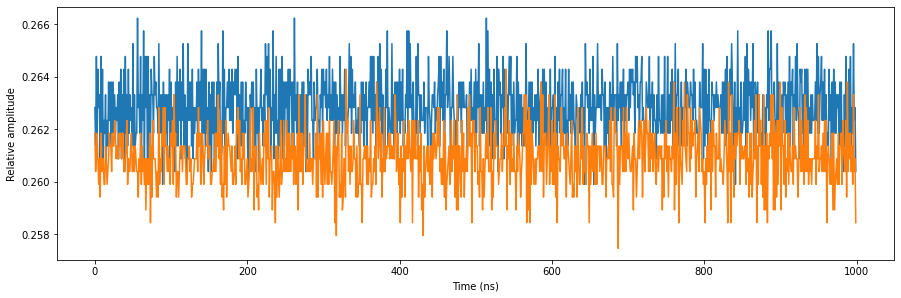

In [9]:
#Wait for the sequencer to stop with a timeout period of one minute.
pulsar.get_acquisition_state(0, 1)

#Move acquisition data from temporary memory to acquisition list.
pulsar.store_scope_acquisition(0, "non_weighed")

#Get acquisition list from instrument.
non_weighed_acq = pulsar.get_acquisitions(0)["non_weighed"]

#Plot acquired signal on both inputs.
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))
ax.plot(non_weighed_acq["acquisition"]["scope"]["path0"]["data"][0:1000])
ax.plot(non_weighed_acq["acquisition"]["scope"]["path1"]["data"][0:1000])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')
matplotlib.pyplot.show()

To check if the integration results match with what we expect, we need to divide the integration results by the integration length which was set through the 
corresponding QCoDeS parameter. Note that the 'valid' key of the dictionary indicates if the bin was actually set during the sequence.

In [10]:
int_len = pulsar.sequencer0_integration_length_acq()
bins = non_weighed_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val/int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val/int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.26278309721543724,
   0.2627322911577919,
   0.2627635564240352,
   0.2627674645823156,
   0.2626844162188569,
   0.2628490473864192,
   0.2628314606741573,
   0.26285588666340987,
   0.26264777723497806,
   0.2628339032730826],
  'path1': [0.2607840742550073,
   0.26078602833414755,
   0.26080068392769906,
   0.26082120175867124,
   0.2608514899853444,
   0.26086516853932584,
   0.2608685881778212,
   0.26093209574987786,
   0.26090034196384954,
   0.26094723986321444]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Weighed acquisition
-------------------

Next we will show weighed integrations. To do this, we will need to modify the sequence program slightly and reupload the program. We will be using a the gaussian weight to integrate over input path 0 and the sine weight to integrate over input path 1. The integration length of a weighed integration is determined by the weight length. 

In [11]:
#Sequence program.
seq_prog = """
      move            0,R0            #Loop iterator.
      move            0,R1            #Weight for path 0.
      move            1,R2            #Weight for path 1.
      nop

loop: acquire_weighed 1,R0,R1,R2,1200 #Acquire bins and store them in "weighed" acquisition.
      add             R0,1,R0         #Increment iterator
      nop                             #Wait a cycle for R0 to be available.
      jlt             R0,10,@loop     #Run until number of iterations is done.

      stop                            #Stop.
"""

In [12]:
#Reformat waveforms/weights to lists if necessary.
for name in waveforms_weights:
    if str(type(waveforms_weights[name]["data"]).__name__) == "ndarray":
        waveforms_weights[name]["data"] = waveforms_weights[name]["data"].tolist()  # JSON only supports lists

#Add sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": waveforms_weights, "weights": waveforms_weights, "acquisitions": acquisitions, "program": seq_prog}
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

In [13]:
#Upload waveforms weights and programs.
pulsar.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "sequence.json"))

Let's start the sequence and retrieve the results.

In [14]:
#Arm and start sequencer.
pulsar.arm_sequencer(0)
pulsar.start_sequencer()

#Print status of sequencer.
print("Status:")
print(pulsar.get_sequencer_state(0, 1))

Status:
{'status': 'STOPPED', 'flags': ['ACQ SCOPE DONE PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ BINNING DONE']}


In [15]:
#Wait for the sequencer to stop with a timeout period of one minute.
pulsar.get_acquisition_state(0, 1)

#Get acquisition list from instrument.
weighed_acq = pulsar.get_acquisitions(0)["weighed"]

To check if the integration results match with what we expect, we need to divide the integration results by the integration length again. In this case the integration
length is determined by the length of the weights.

In [16]:
int_len = waveform_weight_length
bins = weighed_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val/int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val/int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.07910445278505202,
   0.07907718883075601,
   0.07903973246521435,
   0.07903070666244413,
   0.0790325514391605,
   0.07906132208043401,
   0.07909073469445875,
   0.07906532347193182,
   0.07907172132304936,
   0.07901295933766868],
  'path1': [-4.6601891854718145e-05,
   1.575617508975487e-05,
   -0.00010222680221121826,
   -0.00016008986663911036,
   -7.573369251987192e-05,
   -8.162082925537445e-05,
   -0.00010531813568249222,
   -9.295876808690608e-06,
   -8.887623505175994e-05,
   3.156922880616854e-05]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Large number of bins
--------------------

The Pulsar QRM supports up to 131072 bins. To show that, we need to change the program slightly again. We will use the non-weighed acquisition program,
but now we will loop over the maximum number of acquisitions while storing each result in a separate bin.

In [17]:
#Sequence program.
seq_prog = """
      move    0,R0            #Loop iterator.
      nop

loop: acquire 2,R0,1200       #Acquire bins and store them in "large" acquisition.
      add     R0,1,R0         #Increment iterator
      nop                     #Wait a cycle for R0 to be available.
      jlt     R0,131072,@loop #Run until number of iterations is done.

      stop                    #Stop.
"""

In [18]:
#Reformat waveforms/weights to lists if necessary.
for name in waveforms_weights:
    if str(type(waveforms_weights[name]["data"]).__name__) == "ndarray":
        waveforms_weights[name]["data"] = waveforms_weights[name]["data"].tolist()  # JSON only supports lists

#Add sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": waveforms_weights, "weights": waveforms_weights, "acquisitions": acquisitions, "program": seq_prog}
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

In [19]:
#Upload waveforms weights and programs.
pulsar.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "sequence.json"))

Let's start the sequence and retrieve the results.

In [20]:
#Arm and start sequencer.
pulsar.arm_sequencer(0)
pulsar.start_sequencer()

#Print status of sequencer.
print("Status:")
print(pulsar.get_sequencer_state(0, 1))

Status:
{'status': 'STOPPED', 'flags': ['ACQ SCOPE DONE PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ BINNING DONE']}


In [21]:
#Wait for the sequencer to stop with a timeout period of one minute.
pulsar.get_acquisition_state(0, 1)

#Get acquisition list from instrument.
large_acq = pulsar.get_acquisitions(0)["large"]

Since the number of bins is now to large to simply print, we will check the number of bins and we will check the bins for NaN values which indicate that a bin is not written. 

In [22]:
int_len = pulsar.sequencer0_integration_length_acq()
bins = large_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val/int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val/int_len) for val in bins["integration"]["path1"]]

print("Number of bins: {}".format(len(bins["avg_cnt"])))
for it, val in enumerate(bins["integration"]["path0"]):
    if math.isnan(val):
        Exception("NaN found at index {}.".format(it))
for it, val in enumerate(bins["integration"]["path0"]):
    if math.isnan(val):
        Exception("NaN found at index {}.".format(it))
for it, val in enumerate(bins["integration"]["path0"]):
    if math.isnan(val):
        Exception("NaN found at index {}.".format(it))
print("All values are valid.")

Number of bins: 131072
All values are valid.


We will also plot the integration results in every bin to visualize the contents.

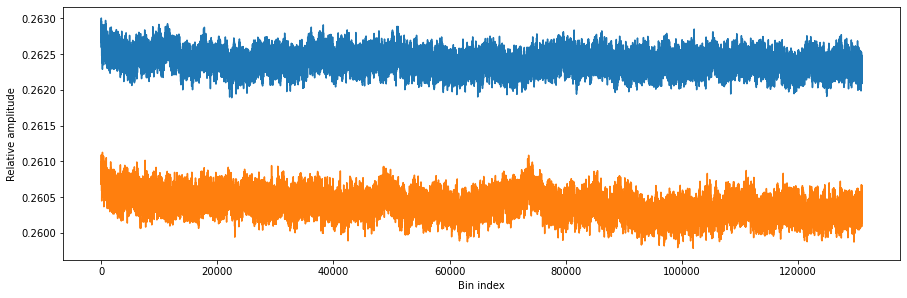

In [23]:
#Plot bins
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))
ax.plot(bins["integration"]["path0"])
ax.plot(bins["integration"]["path1"])
ax.set_xlabel('Bin index')
ax.set_ylabel('Relative amplitude')
matplotlib.pyplot.show()

Averaging
--------------------

As you might have noticed, the acquisition results also contain an average counter. This average counter reflects the number of times a bin as been averaged during the sequence.
Each time a the sequence writes to the same bin the results are automatically accumulated and the average counter is increased. Upon retrieval of the acquisition results, each
result is divide by the average counter and therefore automatically averaged. To show this, we will change the sequence one last time. This time we will average 10 bins a 1000
times each.

In [24]:
#Sequence program.
seq_prog = """
      move    0,R1         #Average iterator.

avg:  move    0,R0         #Bin iterator.
      nop

loop: acquire 3,R0,1200    #Acquire bins and store them in "avg" acquisition.
      add     R0,1,R0      #Increment bin iterator
      nop                  #Wait a cycle for R0 to be available.
      jlt     R0,10,@loop  #Run until number of avg iterations is done.
      add     R1,1,R1      #Increment avg iterator
      nop                  #Wait a cycle for R1 to be available.
      jlt     R1,1000,@avg #Run until number of average iterations is done.

      stop                 #Stop.
"""

In [25]:
#Reformat waveforms/weights to lists if necessary.
for name in waveforms_weights:
    if str(type(waveforms_weights[name]["data"]).__name__) == "ndarray":
        waveforms_weights[name]["data"] = waveforms_weights[name]["data"].tolist()  # JSON only supports lists

#Add sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": waveforms_weights, "weights": waveforms_weights, "acquisitions": acquisitions, "program": seq_prog}
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

In [26]:
#Upload waveforms weights and programs.
pulsar.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "sequence.json"))

Let's start the sequence and retrieve the results.

In [27]:
#Arm and start sequencer.
pulsar.arm_sequencer(0)
pulsar.start_sequencer()

#Print status of sequencer.
print("Status:")
print(pulsar.get_sequencer_state(0, 1))

Status:
{'status': 'STOPPED', 'flags': ['ACQ SCOPE DONE PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ BINNING DONE']}


Note that the average count of each bin is now set to a 1000.

In [28]:
#Wait for the sequencer to stop with a timeout period of one minute.
pulsar.get_acquisition_state(0, 1)

#Get acquisition list from instrument.
avg_acq = pulsar.get_acquisitions(0)["avg"]

In [29]:
int_len = pulsar.sequencer0_integration_length_acq()
bins = avg_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val/int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val/int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.2623844054714216,
   0.26238013776257935,
   0.26238450757205667,
   0.2623816687835857,
   0.2623839916951637,
   0.26238157889594527,
   0.26238090083048365,
   0.2623823893502687,
   0.26238615388373226,
   0.2623849164631168],
  'path1': [0.26064035026868587,
   0.26063904396678067,
   0.2606426585246703,
   0.26063935173424524,
   0.26063819785051295,
   0.26064604543234005,
   0.26064677283829996,
   0.26064003321934537,
   0.2606426253053249,
   0.2606444797264289]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]}

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection.

In [30]:
#Stop sequencer.
pulsar.stop_sequencer()
    
#Print status of sequencer.
print("Status:")
print(pulsar.get_sequencer_state(0))
print()

#Print an overview of the instrument parameters.
print("Snapshot:")
pulsar.print_readable_snapshot(update=True)
    
#Close the instrument connection.
pulsar.close()

Status:
{'status': 'STOPPED', 'flags': ['FORCED STOP', 'ACQ SCOPE DONE PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ BINNING DONE']}

Snapshot:
qrm:
	parameter                                  value
--------------------------------------------------------------------------------
IDN                                         :	{'manufacturer': 'Qblox', 'mode...
in0_gain                                    :	-6 (dB)
in1_gain                                    :	-6 (dB)
out0_offset                                 :	0 (V)
out1_offset                                 :	0 (V)
reference_source                            :	internal 
scope_acq_avg_mode_en_path0                 :	False 
scope_acq_avg_mode_en_path1                 :	False 
scope_acq_sequencer_select                  :	0 
scope_acq_trigger_level_path0               :	0 
scope_acq_trigger_level_path1               :	0 
scope_acq_trigger_mode_path0                :	sequencer 
scope_acq_trigger_mode_path1                :	sequencer 
sequencer0_